In [1]:
import os
new_working_directory = "C:\\Users\\ianja\\REPOS\\Pepperpot\\"
os.chdir(new_working_directory)

In [4]:
import os
import shutil
import re

class ParameterValues:
    def __init__(self, epsnx, alfax, betax, epsny, alfay, betay, epsnz, alfaz, betaz):
        self.epsnx = epsnx
        self.alfax = alfax
        self.betax = betax
        self.epsny = epsny
        self.alfay = alfay
        self.betay = betay
        self.epsnz = epsnz
        self.alfaz = alfaz
        self.betaz = betaz

# Specify the local directory containing the images
local_directory = 'local-images-before-after-propagation-bw'

# Check the current working directory
print(f"Current working directory: {os.getcwd()}")

# Check if the local_directory exists in the current working directory
if not os.path.exists(local_directory):
    print(f"The directory '{local_directory}' does not exist in the current working directory.")
else:
    print(f"The directory '{local_directory}' exists.")

# Create the target directories for organizing the images
target_directory_2param = os.path.join(local_directory, '2-param')
target_directory_3param = os.path.join(local_directory, '3-param')
target_directory_6param = os.path.join(local_directory, '6-param')

# Create the target directories if they don't exist
os.makedirs(target_directory_2param, exist_ok=True)
os.makedirs(target_directory_3param, exist_ok=True)
os.makedirs(target_directory_6param, exist_ok=True)

# Regular expression pattern for extracting parameters from filename
pattern = r"epsnx([\d.-]+)_alfax([\d.-]+)_betax([\d.-]+)_epsny([\d.-]+)_alfay([\d.-]+)_betay([\d.-]+)_epsnz([\d.-]+)_alfaz([\d.-]+)_betaz([\d.-]+)_*[\d]*\.png"

# Iterate over the images in the local directory
for filename in os.listdir(local_directory):
    print(filename)
    if filename.endswith('.png'):
        source_path = os.path.join(local_directory, filename)

        # Extract parameters from filename using regex
        match = re.match(pattern, filename)
        if match:
            params = ParameterValues(*match.groups())
            varied_params = sum(param != '0.0' for param in vars(params).values())

            # Move the file to the corresponding target directory based on the number of varied parameters
            print(params.alfay + " " + params.betay)
            if filename.startswith("epsnx0.1_"):
                target_path = os.path.join(target_directory_2param, filename)
            elif params.alfay == "-0.55" and params.betay == "170.0":
                target_path = os.path.join(target_directory_3param, filename)
            else:
                target_path = os.path.join(target_directory_6param, filename)

            shutil.move(source_path, target_path)

print("Image organization completed.")


Current working directory: c:\Users\ianja\REPOS\Pepperpot
The directory 'local-images-before-after-propagation-bw' exists.
2-param
3-param
6-param
epsnx0.03000_alfax1.73108_betax175.38769_epsny0.05898_alfay-2.39092_betay491.92688_epsnz5.00000_alfaz0.10000_betaz10.00000.png
-2.39092 491.92688
epsnx0.03001_alfax2.01271_betax157.04349_epsny0.21268_alfay0.41166_betay138.38033_epsnz5.00000_alfaz0.10000_betaz10.00000.png
0.41166 138.38033
epsnx0.03012_alfax-4.2746_betax223.43519_epsny0.1_alfay-0.55_betay170.0_epsnz5.0_alfaz0.1_betaz10.0.png
-0.55 170.0
epsnx0.03015_alfax0.09003_betax315.00396_epsny0.19579_alfay-0.23962_betay360.68472_epsnz5.00000_alfaz0.10000_betaz10.00000.png
-0.23962 360.68472
epsnx0.03023_alfax-4.22694_betax57.86096_epsny0.03086_alfay-3.55328_betay251.12065_epsnz5.00000_alfaz0.10000_betaz10.00000.png
-3.55328 251.12065
epsnx0.03030_alfax4.16580_betax163.94593_epsny0.07499_alfay-3.92554_betay163.53697_epsnz5.00000_alfaz0.10000_betaz10.00000.png
-3.92554 163.53697
epsnx0.03

In [5]:
import os
import random
import shutil
import time

random.seed(42)

original_folders = ["local-images-before-after-propagation-bw/6-param/"]
train_folder = "./train"
test_folder = "./test"

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

train_ratio = 0.8

file_list = []

for folder in original_folders:
    file_list.extend([os.path.join(folder, file) for file in os.listdir(folder)])
    print(len(file_list))

random.shuffle(file_list)

train_size = int(len(file_list) * train_ratio)

train_files = file_list[:train_size]
test_files = file_list[train_size:]

for src_path in train_files:
    file = os.path.basename(src_path)
    dst_path = os.path.join(train_folder, file)

    # Check if a file with the same name already exists in the target directory
    if os.path.exists(dst_path):
        # Split filename into name and extension
        base, ext = os.path.splitext(file)
        # Append a unique identifier to the filename
        new_filename = f"{base}_{random.randint(1000,9999)}{ext}"
        dst_path = os.path.join(train_folder, new_filename)

    shutil.copy(src_path, dst_path)

for src_path in test_files:
    file = os.path.basename(src_path)
    dst_path = os.path.join(test_folder, file)

    # Check if a file with the same name already exists in the target directory
    if os.path.exists(dst_path):
        # Split filename into name and extension
        base, ext = os.path.splitext(file)
        # Append a unique identifier to the filename
        new_filename = f"{base}_{random.randint(1000,9999)}{ext}"
        dst_path = os.path.join(test_folder, new_filename)

    shutil.copy(src_path, dst_path)

print("Dataset split completed!")


4232
Dataset split completed!


In [8]:
#clear cache and memory
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [2]:
# FLEX 
NAME = "6param-dbwd-nonorm-diff-structure"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import re
import cv2
import numpy as np
from torchvision import transforms
import random

#clear cache and memory
import torch
torch.cuda.empty_cache()
import gc
gc.collect()


# ensure determinism
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 197 * 98, 256)  # Adjusted input size
        self.fc2 = nn.Linear(256, 6) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class CustomDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.pattern = r"epsnx([\d.-]+)_alfax([\d.-]+)_betax([\d.-]+)_epsny([\d.-]+)_alfay([\d.-]+)_betay([\d.-]+)_epsnz([\d.-]+)_alfaz([\d.-]+)_betaz([\d.-]+)\.png"
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_name = self.image_files[index]
        image_path = os.path.join(self.image_dir, image_name)
        image = cv2.imread(image_path)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (394, 197))
        image = self.transform(image)
        matches = re.search(self.pattern, image_name)
        variables = [float(matches.group(i)) for i in range(1, 10) if matches.group(i)]
        emm_x = variables[0] # emmx value
        alfa_x = variables[1] # alfax value
        beta_x = variables[2] # betax value
        emm_y = variables[3] # emmy value
        alfa_y = variables[4] # alfay value
        beta_y = variables[5] # betay value
        return image, torch.tensor([emm_x, alfa_x, beta_x, emm_y, alfa_y, beta_y]) # returns alfa x and betax as the labels


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# batch_size = 4
# learning_rate = 0.0001
# num_epochs = 300

# model = CNN().to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# image_dir = "train" 
# dataset = CustomDataset(image_dir)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# total_steps = len(dataloader)
# for epoch in range(num_epochs):
#     for i, (images, labels) in enumerate(dataloader):
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_steps}], Loss: {loss.item():.4f}")
#     print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
    
# filename = f"cnn_{NAME}_bs{batch_size}_lr{learning_rate}_e{num_epochs}.pth"
# torch.save(model.state_dict(), filename)

In [1]:
# FLEX 
NAME = "3param-dbwd"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import re
import cv2
import numpy as np
from torchvision import transforms
import random

#clear cache and memory
import torch
torch.cuda.empty_cache()
import gc
gc.collect()


# ensure determinism
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 197 * 98, 256)  # Adjusted input size
        self.fc2 = nn.Linear(256, 3) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class CustomDataset(Dataset):
    def __init__(self, image_dir):
        self.image_dir = image_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.pattern = r"epsnx([\d.-]+)_alfax([\d.-]+)_betax([\d.-]+)_epsny([\d.-]+)_alfay([\d.-]+)_betay([\d.-]+)_epsnz([\d.-]+)_alfaz([\d.-]+)_betaz([\d.-]+)\.png"
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.456], std=[0.224])
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_name = self.image_files[index]
        image_path = os.path.join(self.image_dir, image_name)
        image = cv2.imread(image_path)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (394, 197))
        image = self.transform(image)
        matches = re.search(self.pattern, image_name)
        variables = [float(matches.group(i)) for i in range(1, 10) if matches.group(i)]
        emm_x = variables[0] # alfax value
        alfa_x = variables[1] # alfax value
        beta_x = variables[2] # betax value
        return image, torch.tensor([emm_x, alfa_x, beta_x]) # returns alfa x and betax as the labels


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 4
learning_rate = 0.0001
num_epochs = 150

model = CNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

image_dir = "train-dbwd-3p"
dataset = CustomDataset(image_dir)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

total_steps = len(dataloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_steps}], Loss: {loss.item():.4f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")
    
filename = f"cnn_{NAME}_bs{batch_size}_lr{learning_rate}_e{num_epochs}.pth"
torch.save(model.state_dict(), filename)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'train-dbwd-3p'

In [14]:
def evaluate_model(model, test_dataset, num_variables):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    total_mae = torch.zeros(num_variables, device=device)
    total_mape = torch.zeros(num_variables, device=device)
    total_smape = torch.zeros(num_variables, device=device)
    total_mse = torch.zeros(num_variables, device=device)
    total_count = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            absolute_error = torch.abs(outputs - labels)
            total_mae += absolute_error.sum(dim=0)

            non_zero_mask = torch.abs(labels) > 1e-8
            percentage_error = (absolute_error / torch.abs(labels)) * 100
            total_mape += (percentage_error * non_zero_mask).sum(dim=0)

            smape = 200.0 * torch.abs(outputs - labels) / (torch.abs(outputs) + torch.abs(labels) + torch.finfo(torch.float32).eps)
            total_smape += smape.sum(dim=0)
            
            mse = (outputs - labels) ** 2
            total_mse += mse.sum(dim=0)

            total_count += labels.size(0)

    mae = total_mae / total_count
    mape = total_mape / total_count
    smape = total_smape / total_count
    rmse = torch.sqrt(total_mse / total_count)

    return mae.cpu().numpy(), mape.cpu().numpy(), smape.cpu().numpy(), rmse.cpu().numpy()


In [15]:
# Import required libraries
import glob
import torch

# Load models and evaluate their performance
model_dir = './'  # Specify ysour directory where models are saved
test_dataset = CustomDataset('train')  # Specify your test dataset

model_performance = []

# Load each model and evaluate it
for model_file in glob.glob(model_dir + '/*.pth'):
    # Load model
    model = CNN()
    model.load_state_dict(torch.load(model_file))
    model.to(device)

    # Evaluate model
    mae, mape, smape, rmse = evaluate_model(model, test_dataset, 6)
    aggregate_score = np.mean([mae, mape, smape, rmse])
    model_performance.append((model_file, mae, mape, smape, rmse, aggregate_score))

# Sort models based on aggregate score
model_performance.sort(key=lambda x: x[-1])

# Print the performance of each model
for model_info in model_performance:
    model_file, mae, mape, smape, rmse, aggregate_score = model_info
    print(f"Model: {model_file}, Aggregate Score: {aggregate_score:.4f}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Absolute Percentage Error: {mape}")
    print(f"Symmetric Mean Absolute Percentage Error: {smape}")
    print(f"Root Mean Square Error: {rmse}")
    print()


Model: .\cnn_6param-dbwd-nonorm-diff-structure_bs4_lr0.0001_e300.pth, Aggregate Score: 16.0094
Mean Absolute Error: [0.0369101  0.39464563 8.617938   0.03733058 0.4242092  9.579589  ]
Mean Absolute Percentage Error: [33.914337  48.246212   3.6444783 27.624258  94.453285   3.962077 ]
Symmetric Mean Absolute Percentage Error: [27.005058  26.282312   3.584414  29.82015   29.211193   3.9757292]
Root Mean Square Error: [ 0.04654493  0.5239198  15.347017    0.04915312  0.5709207  16.874077  ]

Model: .\cnn_6param-dbwd-nonorm-diff-structure_bs4_lr0.001_e50.pth, Aggregate Score: 37.7075
Mean Absolute Error: [ 0.28493553  0.67575824 17.06706     0.16983724  0.5713975  15.662382  ]
Mean Absolute Percentage Error: [246.44936    77.436035    7.3162637 146.93527    75.00203     6.686828 ]
Symmetric Mean Absolute Percentage Error: [95.77121   40.645905   6.9827714 73.691154  36.497707   6.4636106]
Root Mean Square Error: [ 0.3328231   0.84580535 25.092617    0.20647538  0.723215   23.470499  ]




(process:5312): Pango-WARNING **: 17:24:28.987: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


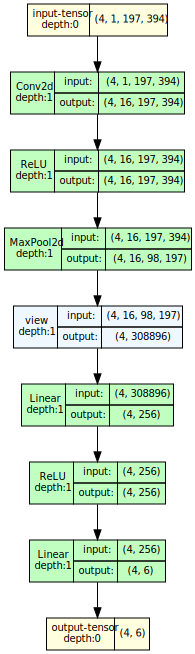

In [5]:
import torchvision
from torchview import draw_graph

model = CNN()
batch_size = 4
# Corrected input size for your grayscale images
input_size = (batch_size, 1, 197, 394)
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model, input_size=input_size, device='meta')
model_graph.visual_graph
